In [3]:
import os

from openai import OpenAI
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

from langchain_openai import ChatOpenAI
llm_model = 'gpt-4o-mini'
chat_model = ChatOpenAI(temperature=0, model=llm_model)

from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

### TavilySearch Tool

In [9]:
from langchain_community.tools import TavilySearchResults

# create tools
tool = TavilySearchResults(max_results=2)
tools = [tool]
result = tool.invoke({"query": "2024년 한국 비상계엄령"})
print(result)

model_with_tools = chat_model.bind_tools(tools)

[{'url': 'https://ko.wikipedia.org/wiki/2024년_대한민국_비상계엄', 'content': '2024년 대한민국 비상계엄 편집 2024년 대한민국 비상계엄 날짜  2024년 12월 3일 2024년 대한민국 비상계엄은 2024년 12월 3일 오후 10시 30분경 대한민국의 윤석열 정부가 선포한 비상계엄이다. 2024년 12월 3일 윤석열은 계엄령을 선포했다. ↑ 이승준 (2024년 12월 3일). ↑ 이승준 (2024년 8월 26일). ↑ 이승준 (2024년 8월 26일). ↑ 가 나 손우성; 이보라 (2024년 9월 10일). ↑ 신수아 (2024년 9월 5일). ↑ 김민형 (2024년 9월 5일). ↑ 박서연 (2024년 9월 4일). ↑ 박재령 (2024년 9월 3일). ↑ 2024-12-03, 유새슬; 박순봉 (2024년 12월 3일). 2024년 12월 3일. ↑ 유정인 (2024년 12월 3일). ↑ 박용하; 신주영 (2024년 12월 3일). ↑ 고한솔 (2024년 12월 3일). ↑ 고한솔 (2024년 12월 3일). ↑ 김민형 (2024년 12월 3일). 이 문서는 2024년 12월 4일 (수) 00:22에 마지막으로 편집되었습니다.'}, {'url': 'https://www.bbc.com/korean/articles/c623dwznlj4o', 'content': '비상계엄: 과거 역사 굴곡 겪었던 세대부터 MZ까지 이들이 보는 2024년 계엄령 - BBC News 코리아 서울에서 택시 기사를 하고 있는 남성 안채순(70) 씨는 30대 시절, 윤 대통령이 비상계엄 직전의 마지막 비상 계엄령 선포(1979년)와 이후 이어졌던 5.18 광주 사태(1980년)를 떠올렸다. 42세 여성 이한의(가명) 씨는 "오래전에 있었던 우리나라에 있었던 그런 일들이 떠오르면서 이게 지금 일어났었다는 것이 영화를 보는 것 같은 느낌이 들었다"고 했다. 이 씨는 주변 또래 친구들의 반응에 대해선 "워낙 정치적으로 어지러운 지금 시대를 살

In [12]:
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)

def chatbot(state: State):
    print(state["messages"])
    return {"messages": [model_with_tools.invoke(state["messages"])]}

# instantiate the ToolNode with the tools
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)  # Add the node to the graph

# add chatbot
graph_builder.add_node("chatbot", chatbot)

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Compile the graph
graph = graph_builder.compile()

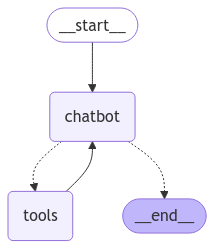

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

# 챗봇 실행
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

[HumanMessage(content='안녕, 내 이름은 피노키오야', additional_kwargs={}, response_metadata={}, id='f5cc0d74-84e2-40ac-aa2b-580356537bd6')]
Assistant: 안녕하세요, 피노키오! 어떻게 도와드릴까요?
[HumanMessage(content='2024년 한국에서 일어난 비상계엄령에 대해 알려줘', additional_kwargs={}, response_metadata={}, id='70757813-619b-46f6-8051-7d468c7826a8')]
Assistant: 
Assistant: [{"url": "https://www.hani.co.kr/arti/politics/bluehouse/1170584.html", "content": "윤석열 대통령이 3일 밤 긴급 대국민 담화를 발표해 “종북 세력을 척결하고, 자유 헌정질서를 지키기 위해 비상계엄을 선포한다”고 말하고 있다. 대한민국 정부 수립 이후 총 16번의 계엄령이 선포됐고, 이 가운데 비상계엄령은 12번 선포됐다. 가장 최근 비상계엄은 1979년 10·26 사건 이후 다음날 최규하 대통령 권한대행이 내린 것이었다. 가장 최근 선포된 비상 계엄령은 45년 전인 1979년 10월27일 있었다. 계엄은 1공화국 시절인 1948년 10월 여순사건 당시 여수·순천 일대에 선포된 것이 처음이었다. 이후 비상계엄은 한국전쟁 시절(1950년 12월∼1951년 4월)처럼 한반도의 큰 아픔이 있을 때 4·19 혁명(1960년 4월19일∼6월17일)과 같은 시민들의 항쟁이 펼쳐질 때 뒷따랐다. 시민들이 한일수교에 반대한 6·3항쟁(1964년 6∼7월)을 비롯해 1972년 10월유신을 선포(10∼12월)할 때도 비상 계엄을 선포했다. 또 1979년 부마민주항쟁에도 비상계엄(10월)을 선포해 맞섰다. [속보] 계엄령에 원화 가치 폭락…원-달러 환율 1440원 돌파 [속보] 계엄령에 원화 가치 폭락…원-달러 환율 1440원 돌파  

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("tools", tool_node)  # Add the node to the graph
# add chatbot
graph_builder.add_node("chatbot", chatbot)


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Compile the graph
graph = graph_builder.compile()

### Adding Memory to our Agent

In [15]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [16]:
graph_builder = StateGraph(State)

def chatbot(state: State):
    print(state["messages"])
    return {"messages": [model_with_tools.invoke(state["messages"])]}

# instantiate the ToolNode with the tools
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)  # Add the node to the graph

# add chatbot
graph_builder.add_node("chatbot", chatbot)

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Compile the graph
graph = graph_builder.compile(checkpointer=memory)

In [17]:
config = {"configurable": {"thread_id": "1"}}

user_input = "안녕, 내 이름은 피노키오야."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕, 내 이름은 피노키오야.
[HumanMessage(content='안녕, 내 이름은 피노키오야.', additional_kwargs={}, response_metadata={}, id='031bc726-9513-412a-8d23-5493d095bc06')]
================================== Ai Message ==================================

안녕하세요, 피노키오님! 어떻게 도와드릴까요?


In [18]:
user_input = "2024년 한국 비상계엄령에 대해 알려줘"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

2024년 한국 비상계엄령에 대해 알려줘
[HumanMessage(content='안녕, 내 이름은 피노키오야.', additional_kwargs={}, response_metadata={}, id='031bc726-9513-412a-8d23-5493d095bc06'), AIMessage(content='안녕하세요, 피노키오님! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 91, 'total_tokens': 108, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'stop', 'logprobs': None}, id='run-68e24698-f59c-4e39-a91d-2f9897a732e8-0', usage_metadata={'input_tokens': 91, 'output_tokens': 17, 'total_tokens': 108, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(

In [19]:
user_input = "너 내 이름을 아직 기억하고 있니?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

너 내 이름을 아직 기억하고 있니?
[HumanMessage(content='안녕, 내 이름은 피노키오야.', additional_kwargs={}, response_metadata={}, id='031bc726-9513-412a-8d23-5493d095bc06'), AIMessage(content='안녕하세요, 피노키오님! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 91, 'total_tokens': 108, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'stop', 'logprobs': None}, id='run-68e24698-f59c-4e39-a91d-2f9897a732e8-0', usage_metadata={'input_tokens': 91, 'output_tokens': 17, 'total_tokens': 108, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(con

In [20]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

너 내 이름을 아직 기억하고 있니?
[HumanMessage(content='너 내 이름을 아직 기억하고 있니?', additional_kwargs={}, response_metadata={}, id='b9dc9c9b-c424-467a-af9a-5d2964fb3b7b')]
================================== Ai Message ==================================

죄송하지만, 이전 대화 내용을 기억할 수 없어요. 당신의 이름을 알려주시면 기억하겠습니다!
